On va utiliser différentes méthodes pour la classification supervisée (création d'un modèle permettant de prédire une variable de type binaire). Ainsi, nous utiliserons les modèles suivants :

* $k$-plus proches voisins
* Arbres de décision
* Réseaux de neurones

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.neural_network import MLPClassifier


In [3]:
source = './src/spambase.data'
source_name = './src/spambase.names'

spam = pd.read_csv(source, header=None)
spam_names = pd.read_table(source_name, sep=":", header=None, skiprows=33, names=["var", "type"])
spam.columns = list(spam_names["var"]) + ["spam"]

In [4]:
spam.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [5]:
spam_names.head()

,var,type
0,word_freq_make,continuous.
1,word_freq_address,continuous.
2,word_freq_all,continuous.
3,word_freq_3d,continuous.
4,word_freq_our,continuous.


Toutes les fonctions dans **sklearn** utilisent le même formalisme, à savoir la séparation des données en deux objets :

* $X$ qui contient les variables explicatives
* $y$ qui contient la variable à expliquer

In [6]:
X = spam.drop(["spam"], axis=1)
y = (spam["spam"] == 1)

### $k$-plus proches voisins (ou $k$-NN ou $k$-nearest neightbors)

L'idée de cette méthode, comme son nom l'indique, de rechercher un certain nombre de points proches de celui à prédire. Ce nombre `k` est un des paramètre de la méthode, l'autre étant la méthode à utiliser pour calculer la distance entre deux points (très souvent la distance euclidienne).


Cette méthode a l'avantage d'être rapide, applicable à des données de grandes tailles et ne nécessite pas d'hypothèse forte. Par contre, si la méthode trouvent deux voisins à une distance identique, selon le cas, elle peut n'en retenir qu'un des deux (le premier dans la liste). Et si la valeur de $y$ est différente entre les deux, cela impacte très fortement les résultats.

#### avec $k$ = 5

In [7]:
m_knn = KNeighborsClassifier(n_neighbors=5).fit(X, y)

In [8]:
m_knn.predict(X) * 1

array([1, 1, 1, ..., 0, 0, 0])

In [10]:
t = pd.crosstab(m_knn.predict(X), y)
t

spam,False,True
row_0,,
False,2507,304
True,281,1509


In [11]:
m_knn.score(X, y)

0.8728537274505542

#### En variant le nombre de voisins $k$

On remarque ici que c'est en choisissant $k=1$ que l'on obtient les meilleurs résultats.

In [13]:
r2 = []
roc_auc = []
vn = []
fn = []
fp = []
vp = []

k_val = (1, 2, 5, 10, 15, 20)
for k in k_val:
    m_knn = KNeighborsClassifier(n_neighbors=k).fit(X, y)
    r2 = r2 + [m_knn.score(X, y)]
    fpr, tpr, th = roc_curve(y, pd.DataFrame(m_knn.predict_proba(X))[1])
    roc_auc = roc_auc + [auc(fpr, tpr)]
    p = m_knn.predict(X) * 1
    vn = vn + [sum((1 - y) * (1 - p))]
    fn = fn + [sum((1 - y) * p)]
    fp = fp + [sum(y * (1 - p))]
    vp = vp + [sum(y * p)]

In [14]:
    df = pd.DataFrame({
    "variable": k_val,
    "rsquared": r2,
    "auc": roc_auc,
    "vrais_negatifs": vn,
    "faux_negatifs": fn,
    "faux_positifs": fp,
    "vrais_positifs": vp
})
df

,variable,rsquared,auc,vrais_negatifs,faux_negatifs,faux_positifs,vrais_positifs
0,1,0.999348,0.999462,2785,3,0,1813
1,2,0.915236,0.984954,2788,0,390,1423
2,5,0.872854,0.949596,2507,281,304,1509
3,10,0.833514,0.920519,2516,272,494,1319
4,15,0.818300,0.903861,2408,380,456,1357
5,20,0.805912,0.889517,2437,351,542,1271


### Arbres de décision

Cette méthode itérative cherche, à chaque node, la variable explicative séparant le mieux les modalités à prédire. A la racine de l'arbre, il y a donc tous les individus, et la population est séparée en deux sous-population pour dans chaque fils. L'algorithme permet de définir quelle variable, et surtout quel seuil (dans le cas d'une variable quantitative) ou quelle répartition de modalités (dans le cas d'une variable qualitative), permet de mieux séparer les classes à prédire.

Cette méthode est intéressante, car elle permet de voir rapidement quelles sont les variables ayant le plus d'impact sur la classe à prédire (ce sont celles en premier dans l'arbre). Il existe différentes méthodes dans la façon de choisir la variable ($CART$ par défaut dans **sklearn**). Son défaut principal est l'`overfitting` possible, si l'arbre est trop profond. On parle alors d'élagage pour le rendre plus généralisable.

#### Arbre complet

Vous remarquerez que les performances sont très impressionnantes (seulement 3 mails mal classés).

In [17]:
m_tree = DecisionTreeClassifier().fit(X, y)

In [19]:
t = pd.crosstab(m_tree.predict(X), y)
t

spam,False,True
row_0,,
False,2788,3
True,0,1810


In [20]:
m_tree.score(X, y)

0.9993479678330798

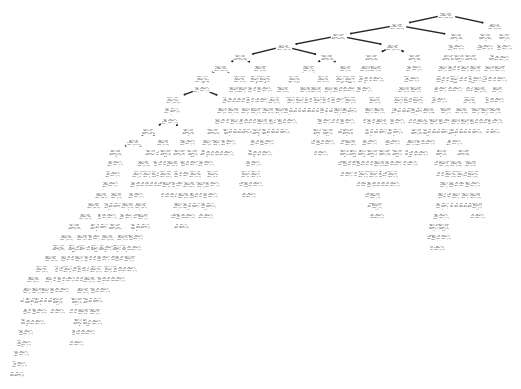

In [23]:
plot_tree(m_tree)
plt.show()

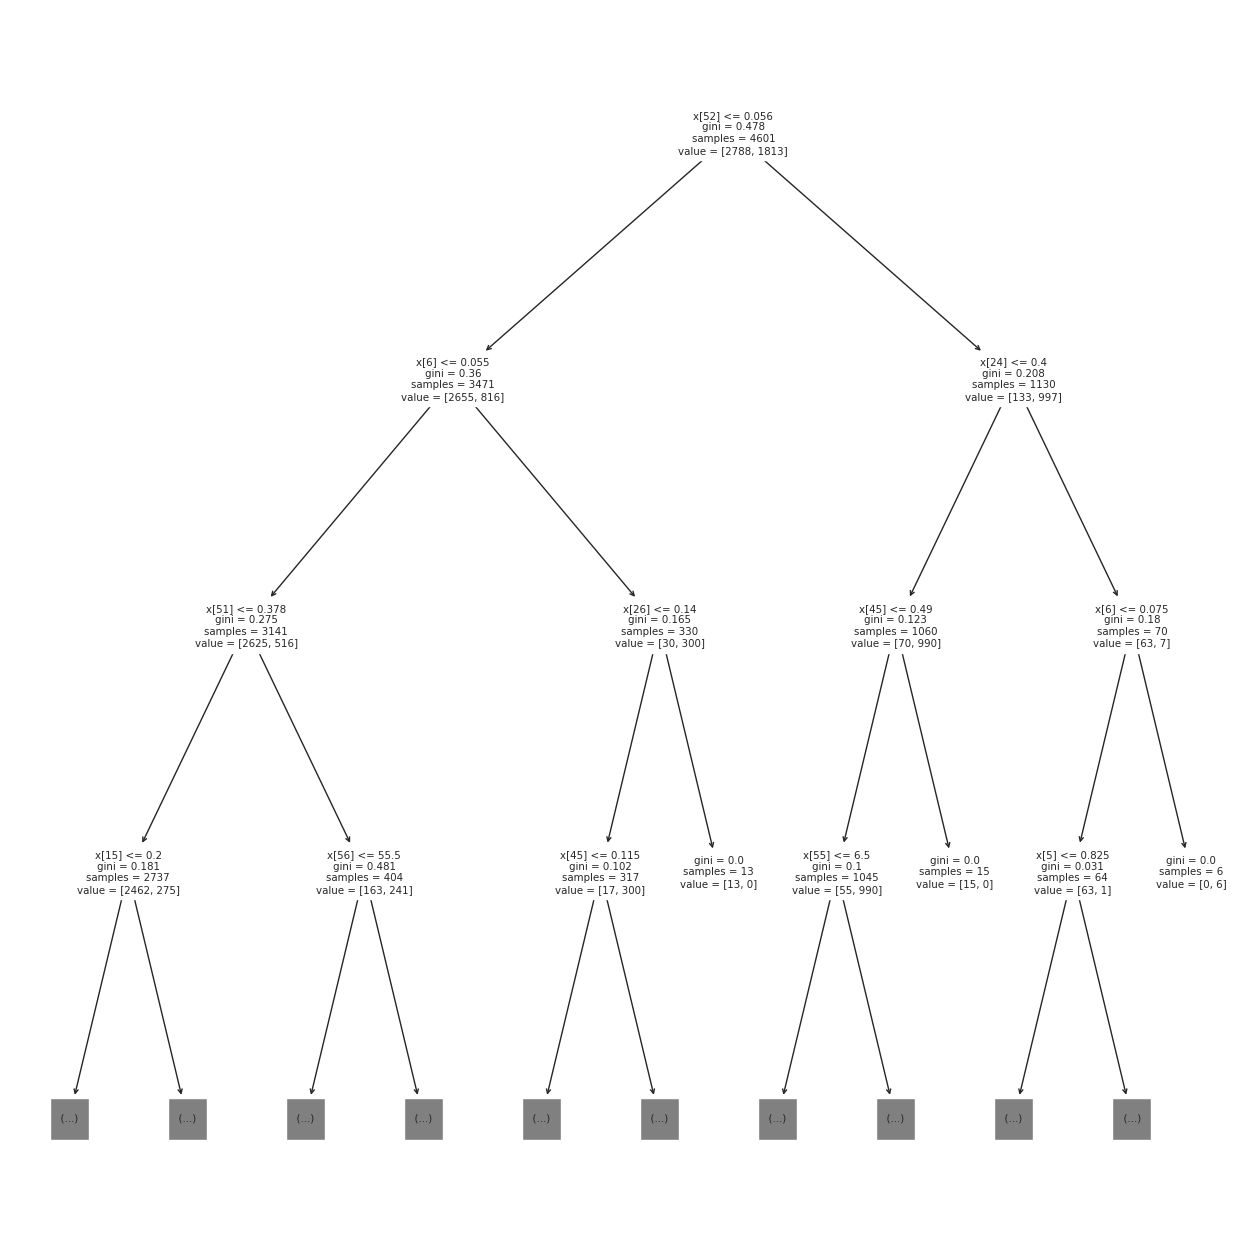

In [24]:
plt.figure(figsize=(16, 16))
plot_tree(m_tree, max_depth = 3)
plt.show()

#### Arbre élagué

Comme indiqué plus haut, il est généralement préférable d'élaguer l'arbre (i.e de couper des branches) pour éviter l'òverfitting`. Cela permet généralement que l'arbre ait de meilleures performances sur des nouvelles données. Pour cela, on utilise une méthode cherchant pour comment l'impureté des feuilles (i.e. la part d'individus mal classés) évolue en fonction d'une valeur alpha. Dans l'idéal, pour la choisir, on doit avoir un jeu de données d'apprentissage (train) et un jeu de données test (test).

Ici, au vu du graphique, nous choisissons une valeur de 0.005 (avec la méthode du coude).

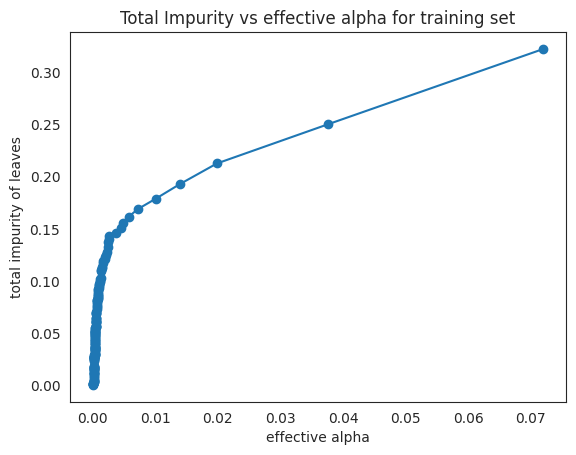

In [25]:
pruning = m_tree.cost_complexity_pruning_path(X, y)

fig, ax = plt.subplots()
ax.plot(pruning.ccp_alphas[:-1], pruning.impurities[:-1], marker="o") # , drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [26]:
m_tree_elague = DecisionTreeClassifier(ccp_alpha=0.005).fit(X, y)

In [27]:
t = pd.crosstab(m_tree_elague.predict(X), y)
t

spam,False,True
row_0,,
False,2640,296
True,148,1517


In [28]:
m_tree_elague.score(X, y)

0.9034992392958052

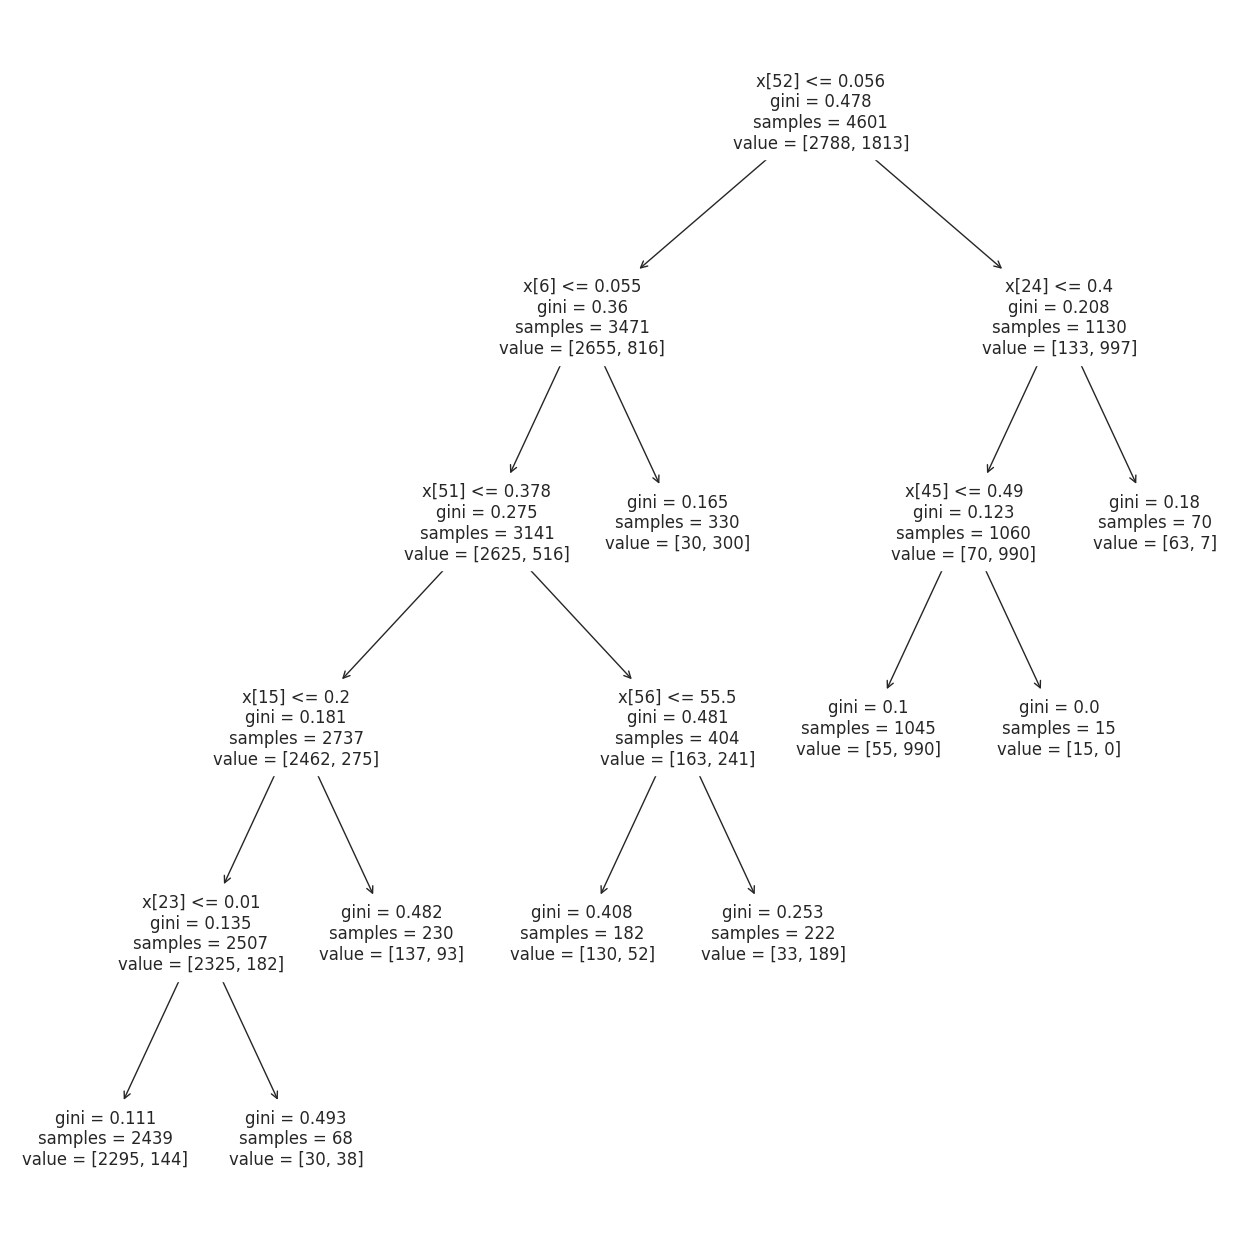

In [29]:
plt.figure(figsize=(16, 16))
plot_tree(m_tree_elague)
plt.show()

### Réseaux de neurones

On parle ici de `perceptron` (simple couche ou multi-couches, en fonction de la complexité que l'on souhaite). L'idée est de connecter des neurones d'entrée (qui prendront les valeurs des variables explicatives) à un neurone de sortie (ou plusieurs en fonction de la variable à expliquer donc). Entre les deux, il y a une ou plusieurs couches de neurones cachés, chacun complètement connecté aux neurones de la couche précédente et de la couche suivante.

A partir de poids aléatoires sur chaque liaison entre neurones, l'algorithme propage l'erreur entre la valeur observée et la valeur prédite par le réseau à chaque couche, avec une méthode de back-propagation. Celle-ci permet de corriger les poids, afin que les neurones s'activent correctement. Cette méthode prend plusieurs paramètres comme le nombre de couches, la taille de chaque couche, la fonction d'activation d'un neurone, et d'autres encore.

Un des défauts majeurs est la difficulté, principalement dans le cadre d'un réseau multi-couches, à percevoir l'impact d'une variable par rapport à une autre. L'autre défaut étant le nombre important de paramètres, et la variabilité des résultats en fonction des valeurs de ceux-ci. Malgré cela, les performances sont plutôt très intéressantes.

#### Perceptron sans couche caché

Ici, on décide de n'avoir aucune couche caché, donc les neurones d'entrées sont directement connectés au neurone de sortie. Dans le cas d'une variable à expliquer quantitative, cela revient au modèle linéaire généralisé, pour information.

Pour notre cas, nous sommes obligé d'augmenter le nombre d'itérations pour que l'algorithme converge, avec des résultats plutôt bons.

In [38]:
preceptron_without_hidden_layer = MLPClassifier(hidden_layer_sizes=(), max_iter=1000).fit(X, y)

In [39]:
y_true = y
y_pred = preceptron_without_hidden_layer.predict(X)

t = pd.crosstab(y_pred, y_true)
t

spam,False,True
row_0,,
False,2671,206
True,117,1607


In [40]:
preceptron_without_hidden_layer.score(X, y)

0.9297978700282548

#### Perceptron simple couche

Par défaut, la fonction choisit un réseau avec une couche cachée à 100 neurones, qui marche plutôt bien ici.

In [37]:
perceptron_simple_couche = MLPClassifier().fit(X, y)

In [41]:
y_true = y
y_pred = perceptron_simple_couche.predict(X)

t = pd.crosstab(y_true, y_pred)
t

col_0,False,True
spam,,
False,2706,82
True,271,1542


In [42]:
perceptron_simple_couche.score(X, y)

0.9232775483590524

#### Perceptron multi-couches

Nous utilisons ici plusieurs couches, dont nous donnons la taille (i.e. nombre de neurones) dans le paramètre `hiden_layer_sizes()`. Ici, après plusieurs essais (avec des choix empiriques), nous calculons un MLP avec 3 couches cachés de 100, 100 et 50 neurones respectivement.

In [43]:
perceptron_multi_couches = MLPClassifier(hidden_layer_sizes=(100, 100, 50)).fit(X,y)

In [44]:
y_true = y
y_pred = perceptron_multi_couches.predict(X)

t = pd.crosstab(y_true, y_pred)
t

col_0,False,True
spam,,
False,2699,89
True,237,1576
